===================================================
## 4. POD-GAN-deriv
#### DCGAN trained to predict the next increment $\alpha_{n+1} = \Delta t f(\alpha_n) + \alpha_n$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

NameError: name 'notebookName' is not defined

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

In [6]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n',value) # MUST RETURN True IF IT CAN!!
print('\n')
print("***Num GPUs Available: ***\n", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***
 True


***Num GPUs Available: ***
 1


## Load data

In [7]:
pod_coeffs = np.loadtxt('POD_coeffs_new_submean.csv', delimiter=',') 

X_pod = np.transpose(pod_coeffs)
step = 0.25
times = np.arange(0, len(X_pod), step, dtype="float64")

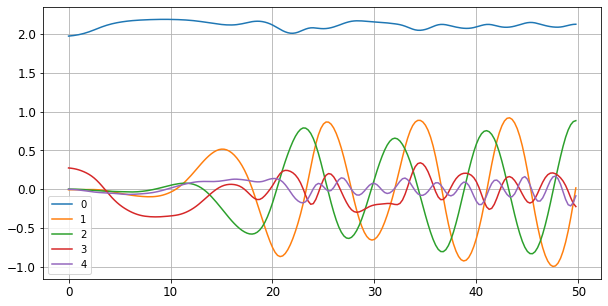

In [8]:
fig, ax = plt.subplots(1,1, figsize=[10,5])
ax.plot(times[0:200], X_pod[0:200]);
ax.grid()
ax.legend(range(5))

## Prepare data

In [9]:
codings_size = X_pod.shape[1]
X_pod.shape

(1999, 5)

In [10]:
def calculate_deriv(X_train, step=step):
    """
    Calculate the 1st order time derivative by (a_n+1 - a_n)/step.
    """
    X_deriv = [[] for i in range(len(X_train)-1)]
    for i in range(len(X_deriv)):
        for j in range(5):
            X_deriv[i].append((X_train[i+1, j] - X_train[i, j]) / step)
    return np.array(X_deriv)

In [11]:
X_deriv_1 = calculate_deriv(X_pod, step=step)
X_deriv_2 = calculate_deriv(X_deriv_1, step=step)
X_deriv_3 = calculate_deriv(X_deriv_2, step=step)
X_deriv_4 = calculate_deriv(X_deriv_3, step=step)
X_deriv_5 = calculate_deriv(X_deriv_4, step=step)
X_deriv_6 = calculate_deriv(X_deriv_5, step=step)

#a0, (a1-a0)/t, ((a2-a1)-(a1-a0))/t^2, ...
X_train = np.concatenate((X_pod[:-6], X_deriv_1[:-5], X_deriv_2[:-4], X_deriv_3[:-3], 
                          X_deriv_4[:-2], X_deriv_5[:-1], X_deriv_6),axis=1)
X_train.shape

(1993, 35)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
np.allclose(X_train, scaler.inverse_transform(X_train_scaled))

True

In [13]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train)-ntimes*step):
        X_current = X_train[i:i+ntimes*step:step] # [start_idx:end_idx:step]
        X_train_concat.append(X_current)
    return np.array(X_train_concat)

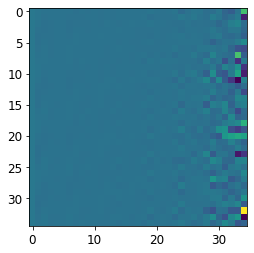

In [14]:
ntimes = 35 # Consecutive times for the GAN
time_step = 4 # step between time levels

X_pod_concat = concat_timesteps(X_train, ntimes, time_step)
X_pod_concat_flatten = X_pod_concat.reshape(X_pod_concat.shape[0], codings_size*ntimes*7)
plt.imshow(X_pod_concat[100, :, :])

(1853, 35, 35)


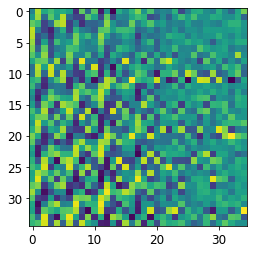

In [15]:
X_train_concat = concat_timesteps(X_train_scaled, ntimes, time_step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes*7)

print(X_train_concat.shape)
plt.imshow(X_train_concat[100, :, :])

## Train the GAN

In [17]:
BATCH_SIZE = 16 #32 64 128
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 35, 35, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
for data in train_dataset:
    print(data)
    break

tf.Tensor(
[[[[7.3579437e-01]
   [1.5928313e-01]
   [1.2297812e-01]
   ...
   [5.0813365e-01]
   [5.5269593e-01]
   [5.7454866e-01]]

  [[6.0856026e-01]
   [4.5368564e-03]
   [4.2994002e-01]
   ...
   [6.1544359e-01]
   [6.2845802e-01]
   [4.7738481e-01]]

  [[5.8459622e-01]
   [7.2129421e-02]
   [7.7418214e-01]
   ...
   [3.0806014e-01]
   [3.9788020e-01]
   [8.5025436e-01]]

  ...

  [[5.3588146e-01]
   [9.9954623e-01]
   [4.8648432e-01]
   ...
   [5.5752581e-01]
   [5.6965488e-01]
   [6.7057508e-01]]

  [[6.7822933e-01]
   [8.7460977e-01]
   [1.5756688e-01]
   ...
   [6.5886831e-01]
   [8.9042425e-01]
   [4.5449147e-01]]

  [[8.3565319e-01]
   [5.5142570e-01]
   [2.6060157e-03]
   ...
   [4.0942344e-01]
   [5.0130832e-01]
   [6.8680161e-01]]]


 [[[8.0325013e-01]
   [2.9775608e-01]
   [4.0046059e-02]
   ...
   [6.0079533e-01]
   [5.6539387e-01]
   [5.1877820e-01]]

  [[6.6029030e-01]
   [5.0211560e-02]
   [2.7419800e-01]
   ...
   [4.7277799e-01]
   [6.5389520e-01]
   [4.5616159e-01

In [20]:
def make_generator_model():
    model = tf.keras.Sequential()
    # input: nz=5, ngf=5
    model.add(keras.layers.Dense(9*9*256, use_bias=False, input_shape=(latent_space,)))
    #model.add(keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((9, 9, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [21]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20736)             2073600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 20736)             82944     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20736)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 128)         294912    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 9, 9, 128)        

(1, 35, 35, 1)


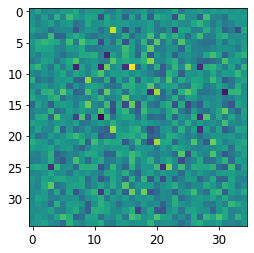

In [22]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[35, 35, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [24]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 9, 9, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)            

In [25]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00048975]], shape=(1, 1), dtype=float32)


In [26]:
gan = keras.models.Sequential([generator, discriminator])

In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [28]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [30]:
notebookName='gan_deriv_6_6'

In [31]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + notebookName[:-6] + '/generator'
discriminator_log_dir = './logs/' + notebookName[:-6] + '/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, latent_space])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)


In [33]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            train_step(batch)
            
        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator", "{}: {:.6f}".format(discriminator, hist[-1][1]), end=' - ')
        print("generator", "{}: {:.6f}".format(gan, hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
                    
            # Save model
            gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
            # plot loss
            
    return hist

In [34]:
discriminator.metrics_names

[]

In [35]:
with tf.device("/gpu:0"):
    hist = train(train_dataset, epochs=5000) #55000

Epoch 1/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f238045fb50>: 0.639912 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f23803b1f90>: 1.140215 - 2s
Epoch 2/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f238045fb50>: 0.506873 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f23803b1f90>: 1.916160 - 0s
Epoch 3/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f238045fb50>: 0.541345 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f23803b1f90>: 1.583337 - 1s
Epoch 4/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f238045fb50>: 0.209380 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f23803b1f90>: 2.573324 - 0s
Epoch 5/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f238045fb5

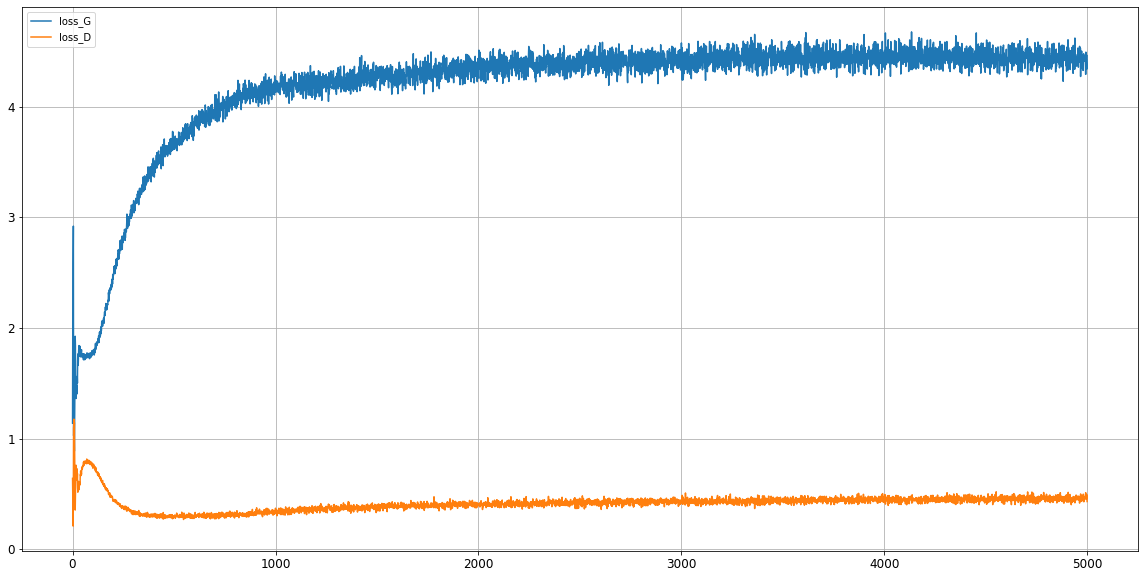

In [36]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_G', 'loss_D'])
#ax.set_yscale('log')
ax.grid()

In [37]:
#from tensorflow.keras.models import load_model
import joblib
joblib.dump(scaler, "scaler-deriv-6-6.pkl")
gan.save("gan-deriv-6-6.h5")

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform(gan.layers[0].predict(noise).reshape(ntimes, 35))

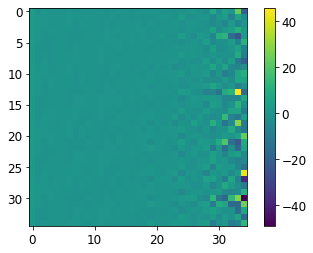

In [39]:
plt.imshow(X_generated)
plt.colorbar()

In [40]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0
# a_n+5
X_5 = step**4 * X_generated[:, 25:30] + 5*X_4 - 10*X_3 + 10*X_2 - 5*X_1 + X_0
# a_n+6
X_6 = step**4 * X_generated[:, 30:35] + 6*X_5 - 15*X_4 + 20*X_3 - 15*X_2 + 6*X_1 - X_0

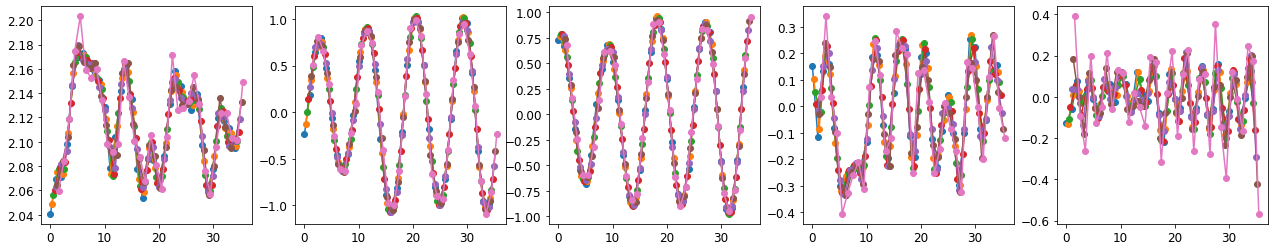

In [41]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,35,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,35+step,step*4), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,35+step*2,step*4), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,35+step*3,step*4), X_3[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*4,35+step*4,step*4), X_4[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*5,35+step*5,step*4), X_5[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*6,35+step*6,step*4), X_6[:,i], '-o')

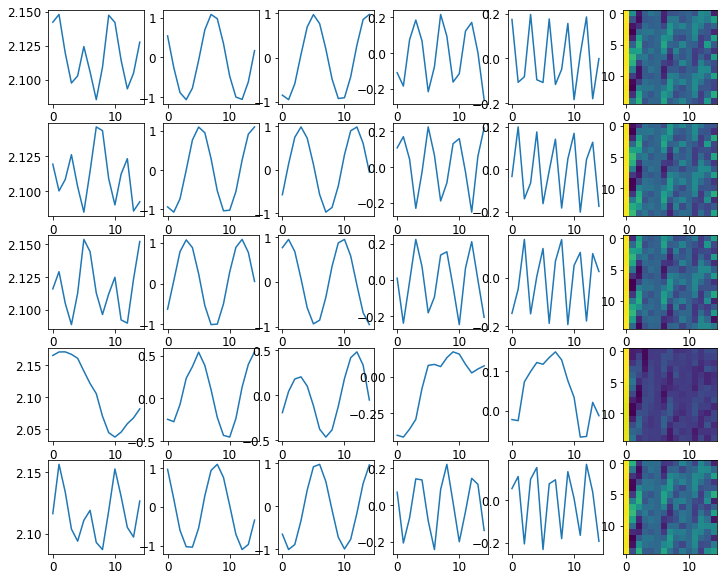

In [38]:
npredict = 5
noise = tf.random.normal(shape=[npredict, latent_space])
X_generated = gan.layers[0].predict(noise).reshape(npredict*ntimes, 15)
X_generated = scaler.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, 15)

fig, ax = plt.subplots(npredict, 6, figsize=[12,npredict*2])
for j in range(npredict):
    for i in range(5):
        ax.flatten()[j*6+i].plot(X_generated[j][:,i], '-')
    im = ax.flatten()[j*6+5].imshow(X_generated[j])
    #fig.colorbar(im, ax=ax.flatten()[j])

## Predict with the GAN

In [ ]:
from tensorflow.keras.models import load_model
import joblib

model_name = 'gan-deriv-6-6.h5'
generator, discriminator = load_model('./{model_name}'.format(model_name=model_name)).layers
scaler = joblib.load("scaler-deriv-6-6.pkl") 

### Predict one point

**In this section we data assimilated the first 8 points generated by the GAN and predict the 9th**

**We use the singular values as weights for the optimization**

In [42]:
df = pd.read_table('singular_values_submean.dat', sep = ',', header=None, engine='python', comment = '#')
 
df.columns = (['index', 's_values', 'normalised s_values', 'cumulative energy'])
df.head()

index  s_values  normalised s_values  cumulative energy
0      0  94.53850             1.000000           0.789434
1      1  34.51350             0.365074           0.894649
2      2  30.57570             0.323420           0.977225
3      3   6.96235             0.073646           0.981506
4      4   5.91322             0.062548           0.984595

In [43]:
#weight = tf.constant(pca_compress.singular_values_, dtype=tf.float32)
values = df.values[:, 1].astype(np.float32)
weight = values[:35]
weight

array([94.5385  , 34.5135  , 30.5757  ,  6.96235 ,  5.91322 ,  5.46066 ,
        5.30333 ,  4.35982 ,  3.44939 ,  3.12954 ,  2.7865  ,  2.62981 ,
        2.13051 ,  2.06319 ,  1.99694 ,  1.96315 ,  1.86048 ,  1.7726  ,
        1.67761 ,  1.6355  ,  1.57014 ,  1.45629 ,  1.40018 ,  1.31616 ,
        1.28613 ,  1.25265 ,  1.18404 ,  1.12233 ,  1.05354 ,  1.04376 ,
        1.02568 ,  0.986064,  0.951295,  0.908308,  0.889358],
      dtype=float32)

In [44]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(5e-2)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size*7])*tf.math.sqrt(loss_weight)
    outp = tf.reshape(outp, [-1, codings_size*7])*tf.math.sqrt(loss_weight)
    return mse(inp, outp)

In [45]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [46]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(5000):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

Loss:  0.0014127096
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[ 0.23537503,  0.7368582 ,  2.1733067 , -0.5704535 , -0.29184452,
         2.453786  ,  1.4247323 , -0.85643625,  0.7852839 ,  0.11238457,
         0.09112066,  0.8904993 , -1.3771657 , -1.4899558 , -0.25434333,
        -2.6780267 , -0.8938108 , -1.1688783 ,  3.046451  , -0.9042041 ,
         1.6305292 , -0.6491624 ,  1.1541433 , -0.35460606,  2.1560347 ,
        -0.11823494, -0.99110216, -2.0475438 , -0.17403491, -2.1075778 ,
         0.01359536,  0.18615678, -2.1516547 , -1.5054704 ,  0.43595523,
         1.0128942 , -2.0681746 ,  0.625104  , -1.026966  , -0.79706055,
        -0.41164938, -2.910533  , -1.3935572 , -1.691606  ,  0.53184503,
        -0.9920251 , -2.5001543 , -0.84683853, -1.2088754 ,  0.01229319,
         0.49359667,  2.1051044 ,  0.7281608 ,  0.3175222 , -0.02025127,
         2.7051451 ,  0.81028265,  1.0550365 ,  1.3719972 , -0.5943066 ,
        -1.2336819 , -0.25559077, -1.2236

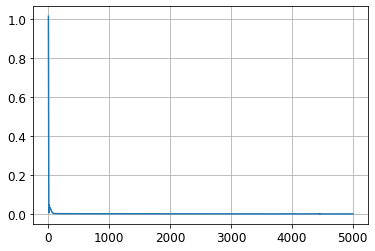

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

n = 500
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*7*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
print(latent_values)

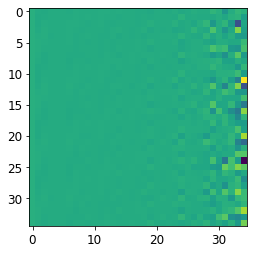

In [48]:
X_generated = scaler.inverse_transform(generator.predict(
    tf.convert_to_tensor(latent_values)).reshape(ntimes, codings_size*7))
plt.imshow(X_generated)

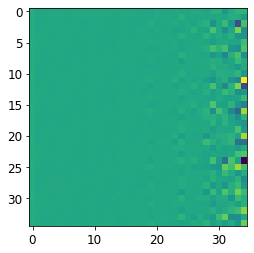

In [49]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size*7))
plt.imshow(X_real)

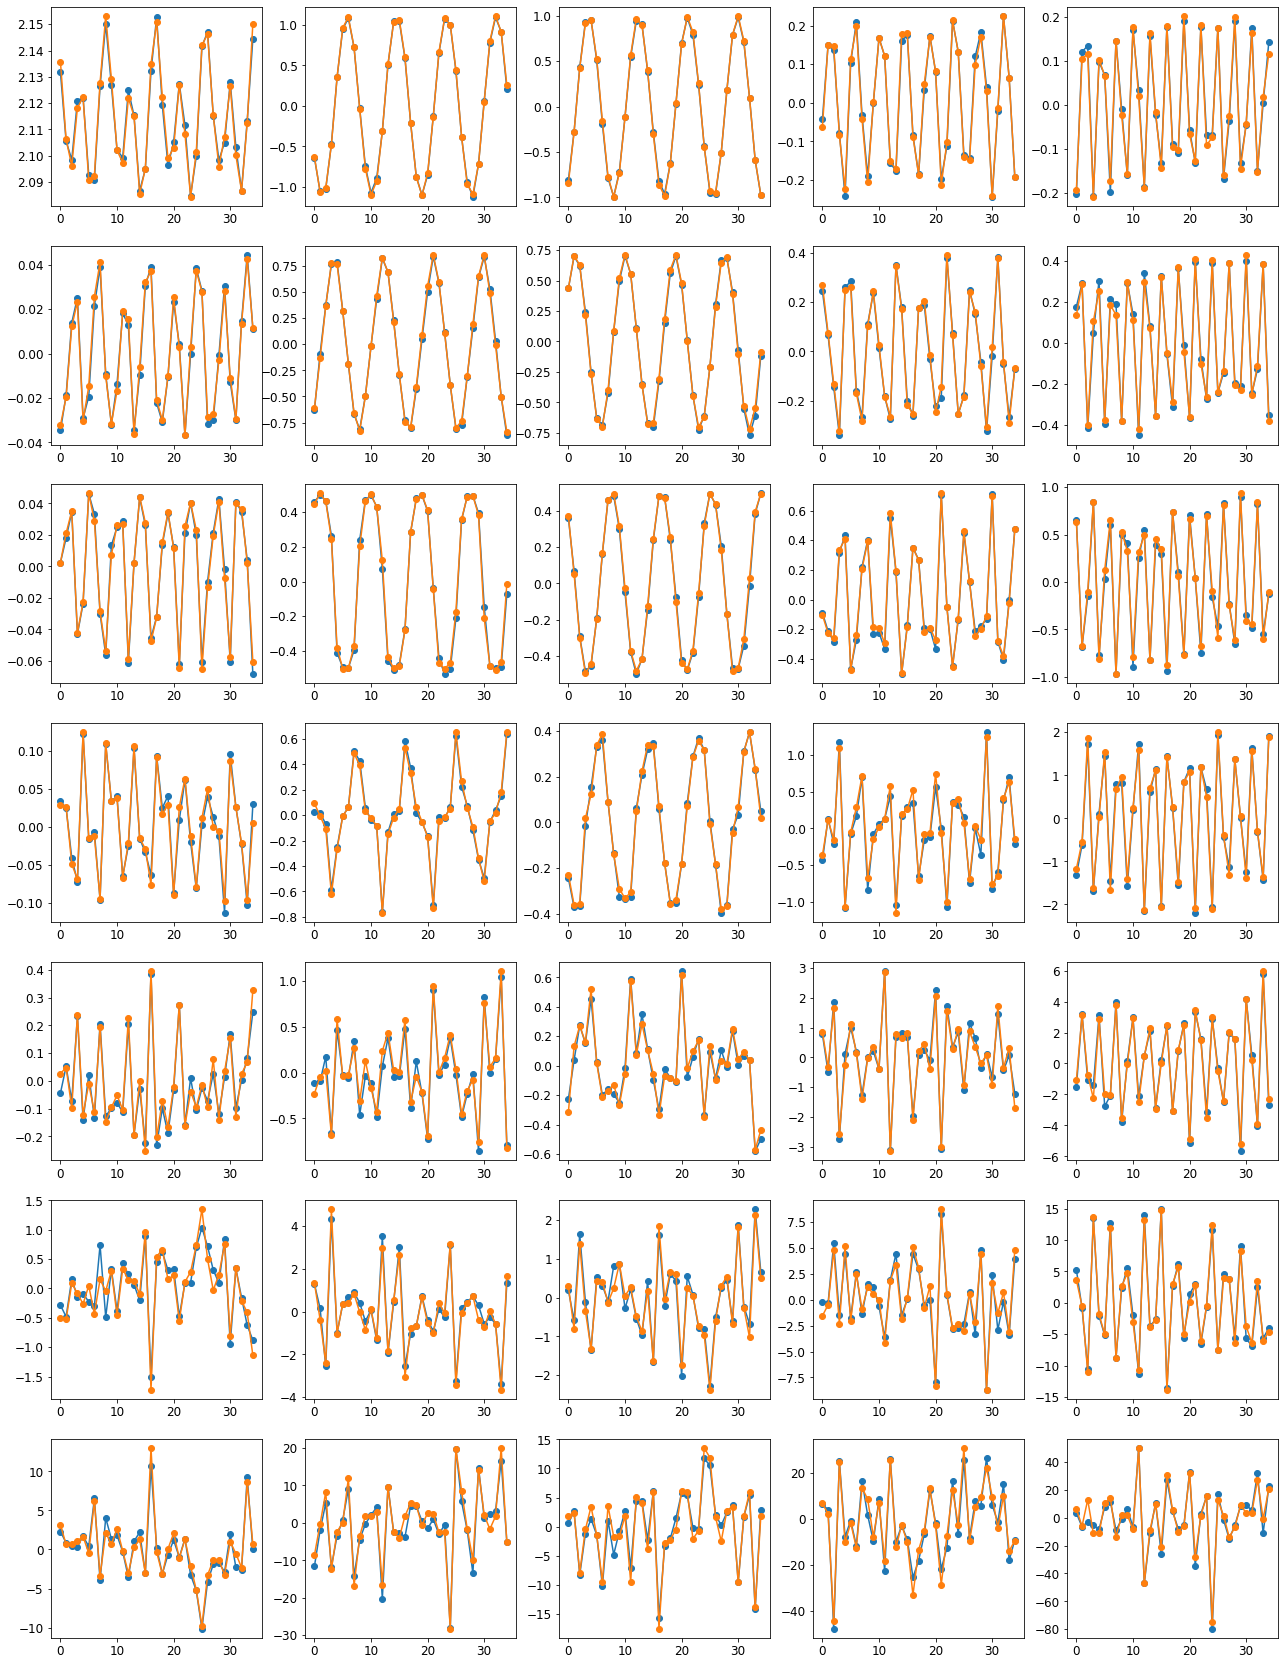

In [50]:
fig, ax = plt.subplots(7, 5, figsize=[22, 30])
for i in range(5):
    ax.flatten()[i].plot(X_generated[:,i], '-o')
    ax.flatten()[i].plot(X_real[:,i],'-o')

    ax.flatten()[i+5].plot(X_generated[:,i+5], '-o')
    ax.flatten()[i+5].plot(X_real[:,i+5],'-o')

    ax.flatten()[i+10].plot(X_generated[:,i+10], '-o')
    ax.flatten()[i+10].plot(X_real[:,i+10],'-o')
    
    ax.flatten()[i+15].plot(X_generated[:,i+15], '-o')
    ax.flatten()[i+15].plot(X_real[:,i+15],'-o')
    
    ax.flatten()[i+20].plot(X_generated[:,i+20], '-o')
    ax.flatten()[i+20].plot(X_real[:,i+20],'-o')
    
    ax.flatten()[i+25].plot(X_generated[:,i+25], '-o')
    ax.flatten()[i+25].plot(X_real[:,i+25],'-o')
    
    ax.flatten()[i+30].plot(X_generated[:,i+30], '-o')
    ax.flatten()[i+30].plot(X_real[:,i+30],'-o')

**The figure below shows the difference between the predicted and real data**

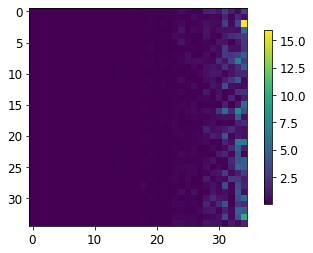

In [51]:
error = X_generated-X_real
plt.imshow(abs(error))
plt.colorbar(shrink=0.8)

**The figure below shows the first 8 points after the data assimilation and the 9th point as a prediction compared with real data**

In [52]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0
# a_n+5
X_5 = step**4 * X_generated[:, 25:30] + 5*X_4 - 10*X_3 + 10*X_2 - 5*X_1 + X_0
# a_n+6
X_6 = step**4 * X_generated[:, 30:35] + 6*X_5 - 15*X_4 + 20*X_3 - 15*X_2 + 6*X_1 - X_0

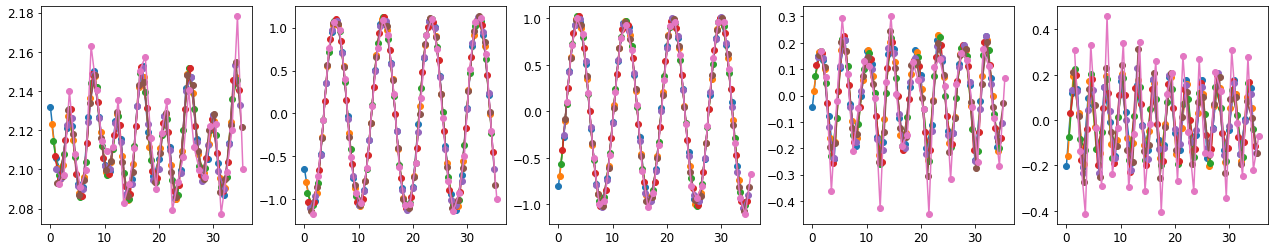

In [53]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,35,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,35+step,step*4), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,35+step*2,step*4), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,35+step*3,step*4), X_3[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*4,35+step*4,step*4), X_4[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*5,35+step*5,step*4), X_5[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*6,35+step*6,step*4), X_6[:,i], '-o')

## Predict multiple points
In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction.

In [54]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  #returns the optimized input that generates the desired output

### Start point = time step 500

In [55]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

n = 500
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*7*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size*7))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*7:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(20): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*7:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)
X_generated = scaler.inverse_transform(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====


The figure below shows the prediction for 3 days in one point of the mesh

In [57]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0
# a_n+5
X_5 = step**4 * X_generated[:, 25:30] + 5*X_4 - 10*X_3 + 10*X_2 - 5*X_1 + X_0
# a_n+6
X_6 = step**4 * X_generated[:, 30:35] + 6*X_5 - 15*X_4 + 20*X_3 - 15*X_2 + 6*X_1 - X_0

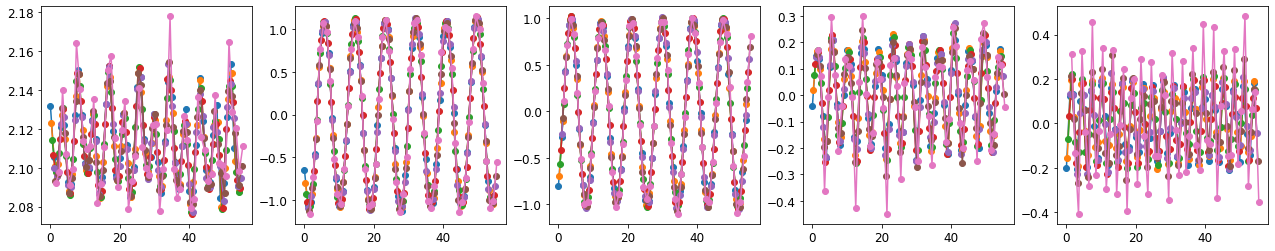

In [59]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,55,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,55+step,step*4), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,55+step*2,step*4), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,55+step*3,step*4), X_3[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*4,55+step*4,step*4), X_4[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*5,55+step*5,step*4), X_5[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*6,55+step*6,step*4), X_6[:,i], '-o')

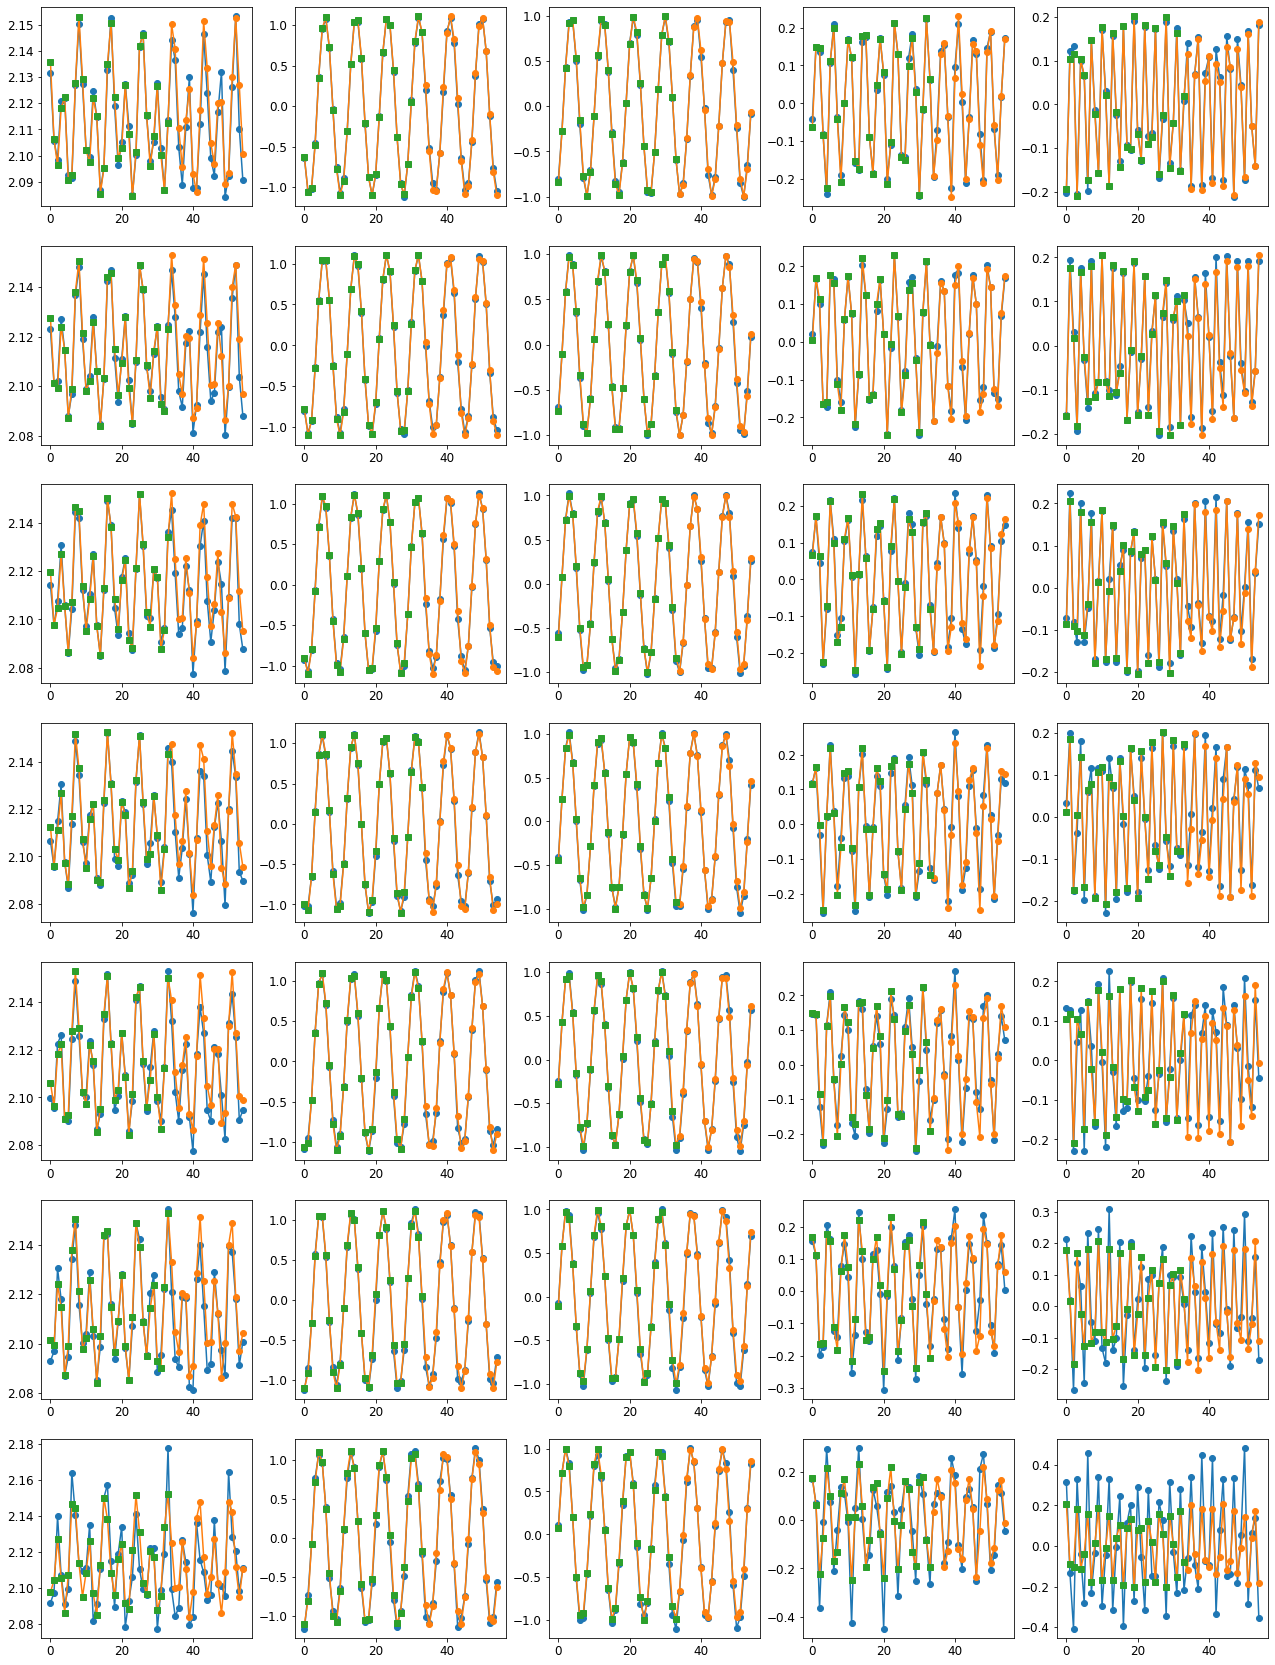

In [61]:
fig, ax = plt.subplots(7, 5, figsize=[22, 30])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,55,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(0,55,step*4),X_pod[500:720:4,i],'-o')
    ax.flatten()[i].plot(np.arange(0,34,step*4),X_pod[500:636:4,i],'s')
    
    ax.flatten()[i+5].plot(np.arange(0,55,step*4), X_1[:,i], '-o')
    ax.flatten()[i+5].plot(np.arange(0,55,step*4), X_pod[501:721:4,i],'-o')
    ax.flatten()[i+5].plot(np.arange(0,34,step*4), X_pod[501:637:4,i],'s')

    ax.flatten()[i+10].plot(np.arange(0,55,step*4), X_2[:,i], '-o')
    ax.flatten()[i+10].plot(np.arange(0,55,step*4), X_pod[502:722:4,i],'-o')
    ax.flatten()[i+10].plot(np.arange(0,34,step*4), X_pod[502:638:4,i],'s')
    
    ax.flatten()[i+15].plot(np.arange(0,55,step*4), X_3[:,i], '-o')
    ax.flatten()[i+15].plot(np.arange(0,55,step*4), X_pod[503:723:4,i],'-o')
    ax.flatten()[i+15].plot(np.arange(0,34,step*4), X_pod[503:639:4,i],'s')
    
    ax.flatten()[i+20].plot(np.arange(0,55,step*4), X_4[:,i], '-o')
    ax.flatten()[i+20].plot(np.arange(0,55,step*4), X_pod[504:724:4,i],'-o')
    ax.flatten()[i+20].plot(np.arange(0,34,step*4), X_pod[504:640:4,i],'s')
    
    ax.flatten()[i+25].plot(np.arange(0,55,step*4), X_5[:,i], '-o')
    ax.flatten()[i+25].plot(np.arange(0,55,step*4), X_pod[505:725:4,i],'-o')
    ax.flatten()[i+25].plot(np.arange(0,34,step*4), X_pod[505:641:4,i],'s')
    
    ax.flatten()[i+30].plot(np.arange(0,55,step*4), X_6[:,i], '-o')
    ax.flatten()[i+30].plot(np.arange(0,55,step*4), X_pod[506:726:4,i],'-o')
    ax.flatten()[i+30].plot(np.arange(0,34,step*4), X_pod[506:642:4,i],'s')

### Start point = time step 1000

In [253]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [254]:
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*3*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size*3))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*3:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(20): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*3:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)
X_generated = scaler.inverse_transform(X_predict)

The figure below shows the prediction for 3 days in one point of the mesh

In [255]:
# Calculate the predicted value of the next time step
# a_n+1 = t*f1(a_n) + a_n
X_pred_1 = step * X_generated[:, 5:10] + X_generated[:, :5]
# a_n+2 = t*(t*f2(a_n) + f1(a_n)) + a_n+1
X_pred_2 = step * (X_generated[:, 10:]*step + X_generated[:, 5:10]) + X_pred_1

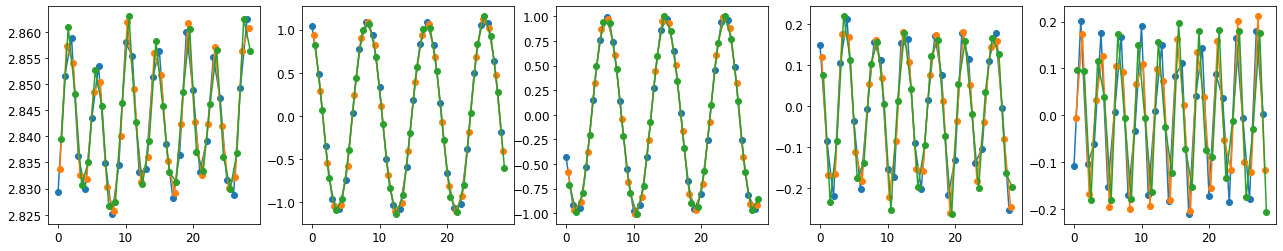

In [256]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,29,step*4), X_generated[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,29+step,step*4), X_pred_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,29+step*2,step*4), X_pred_2[:,i], '-o')

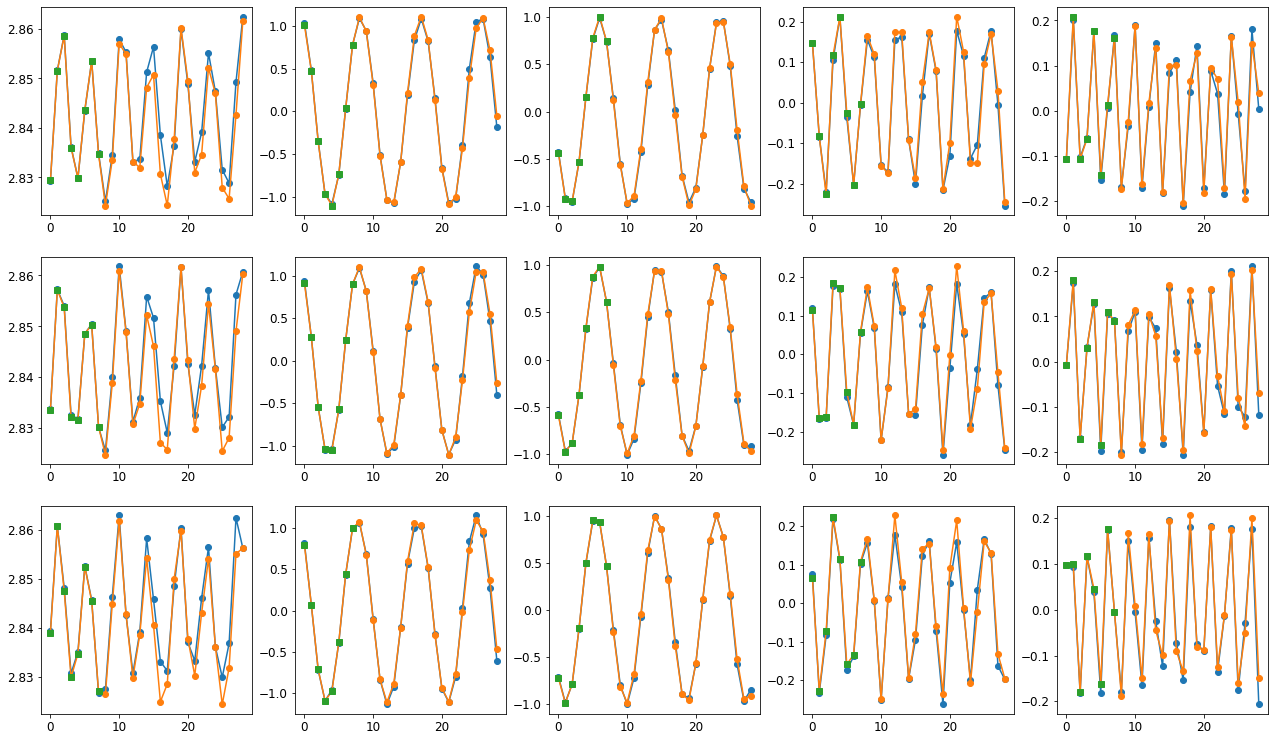

In [257]:
fig, ax = plt.subplots(3, 5, figsize=[22, 13])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,29,step*4), X_generated[:,i], '-o')
    ax.flatten()[i].plot(np.arange(0,29,step*4),X_pod[1000:1116:4,i],'-o')
    ax.flatten()[i].plot(np.arange(0,8,step*4),X_pod[1000:1032:4,i],'s')
    
    ax.flatten()[i+5].plot(np.arange(0,29,step*4), X_pred_1[:,i], '-o')
    ax.flatten()[i+5].plot(np.arange(0,29,step*4), X_pod[1001:1117:4,i],'-o')
    ax.flatten()[i+5].plot(np.arange(0,8,step*4), X_pod[1001:1033:4,i],'s')

    ax.flatten()[i+10].plot(np.arange(0,29,step*4), X_pred_2[:,i], '-o')
    ax.flatten()[i+10].plot(np.arange(0,29,step*4), X_pod[1002:1118:4,i],'-o')
    ax.flatten()[i+10].plot(np.arange(0,8,step*4), X_pod[1002:1034:4,i],'s')

## Predict the whole simulation

### Start point = time step 100

In [180]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [181]:
np.random.seed(42)
tf.random.set_seed(42)

n = 100
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*3*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size*3))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*3:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(200): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*3:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [182]:
X_generated = scaler.inverse_transform(X_predict)
#np.save('X_generatedall.npy',X_generated)

The figure below shows the prediction for one point of the mesh

In [195]:
# Calculate the predicted value of the next time step
# a_n+1 = t*f1(a_n) + a_n
X_pred_1 = step * X_generated[:, 5:10] + X_generated[:, :5]
# a_n+2 = t*(t*f2(a_n) + f1(a_n)) + a_n+1
X_pred_2 = step * (X_generated[:, 10:]*step + X_generated[:, 5:10]) + X_pred_1

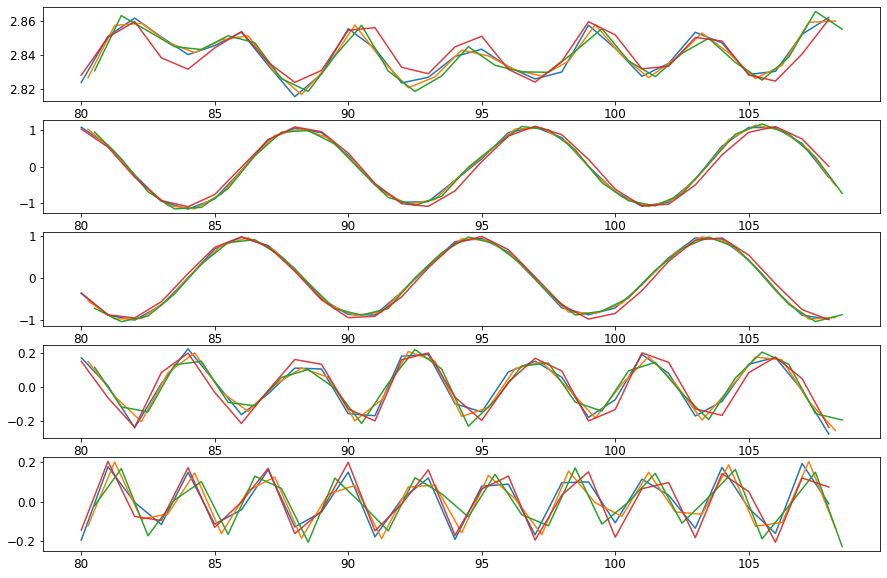

In [209]:
fig, ax = plt.subplots(5,1, figsize=[15,10])
for i in range(5):
    ax.flatten()[i].plot(np.arange(100,109,step*4), X_generated[:,i])
    ax.flatten()[i].plot(np.arange(80+step,109+step,step*4), X_pred_1[:,i])
    ax.flatten()[i].plot(np.arange(80+step*2,109+step*2,step*4), X_pred_2[:,i])
    ax.flatten()[i].plot(np.arange(80,109,step*4),X_pod[332:448:4,i], alpha=0.9)

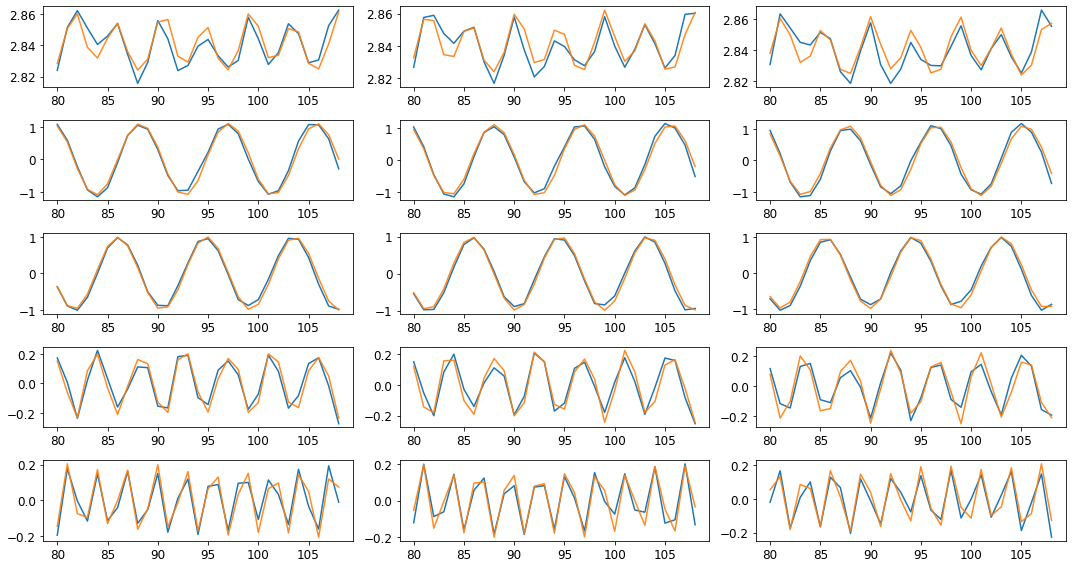

In [212]:
fig, ax = plt.subplots(5,3, figsize=[15,8])
for i in range(5):
    ax.flatten()[i*3].plot(np.arange(80,109,step*4), X_generated[80:,i])
    ax.flatten()[i*3].plot(np.arange(80,109,step*4),X_pod[332:448:4,i], alpha=0.9)
    
    ax.flatten()[i*3+1].plot(np.arange(80,109,step*4), X_pred_1[80:,i])
    ax.flatten()[i*3+1].plot(np.arange(80,109,step*4),X_pod[333:449:4,i], alpha=0.9)
    
    ax.flatten()[i*3+2].plot(np.arange(80,109,step*4), X_pred_2[80:,i])
    ax.flatten()[i*3+2].plot(np.arange(80,109,step*4),X_pod[334:450:4,i], alpha=0.9)
    
plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

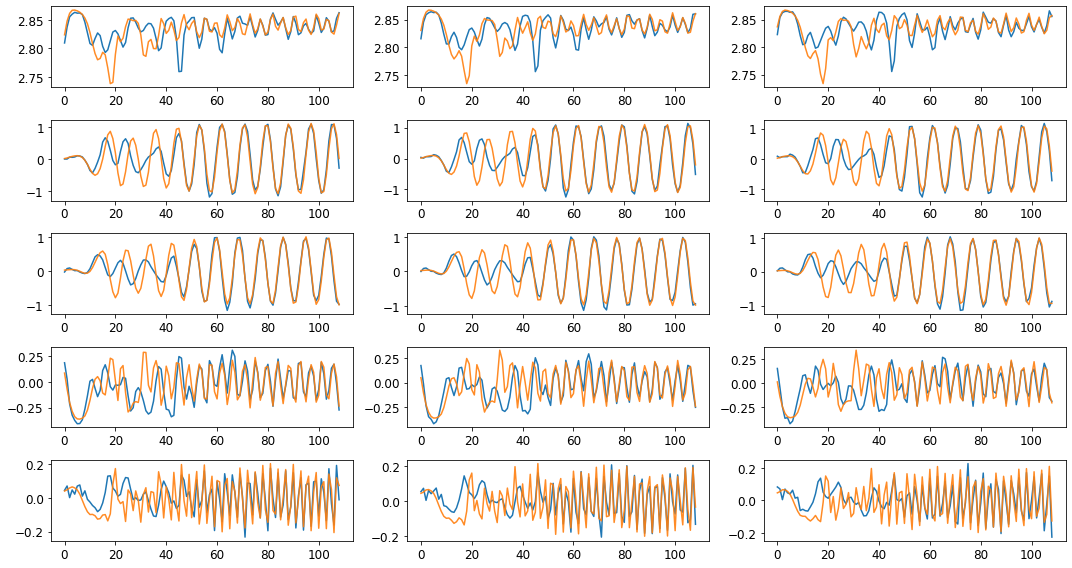

In [217]:
fig, ax = plt.subplots(5,3, figsize=[15,8])
for i in range(5):
    ax.flatten()[i*3].plot(np.arange(0,109,step*4), X_generated[:,i])
    ax.flatten()[i*3].plot(np.arange(0,109,step*4),X_pod[12:448:4,i], alpha=0.9)
    
    ax.flatten()[i*3+1].plot(np.arange(0,109,step*4), X_pred_1[:,i])
    ax.flatten()[i*3+1].plot(np.arange(0,109,step*4),X_pod[13:449:4,i], alpha=0.9)
    
    ax.flatten()[i*3+2].plot(np.arange(0,109,step*4), X_pred_2[:,i])
    ax.flatten()[i*3+2].plot(np.arange(0,109,step*4),X_pod[14:450:4,i], alpha=0.9)
    
plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

### Start point = time step 1000

In [62]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*7*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size*7))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*7:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(200): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size*7:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====
=====20=====
=====21=====
=====22=====
=====23=====
=====24=====
=====25=====
=====26=====
=====27=====
=====28=====
=====29=====
=====30=====
=====31=====
=====32=====
=====33=====
=====34=====
=====35=====
=====36=====
=====37=====
=====38=====
=====39=====
=====40=====
=====41=====
=====42=====
=====43=====
=====44=====
=====45=====
=====46=====
=====47=====
=====48=====
=====49=====
=====50=====
=====51=====
=====52=====
=====53=====
=====54=====
=====55=====
=====56=====
=====57=====
=====58=====
=====59=====
=====60=====
=====61=====
=====62=====
=====63=====
=====64=====
=====65=====
=====66=====
=====67=====
=====68=====
=====69=====
=====70=====
=====71=====
=====72=====
=====73=====
=====74=====
=====75=====
=====76=====
=====77==

In [64]:
X_generated = scaler.inverse_transform(X_predict)
#np.save('X_generatedall.npy',X_generated)

The figure below shows the prediction for one point of the mesh

In [65]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0
# a_n+5
X_5 = step**4 * X_generated[:, 25:30] + 5*X_4 - 10*X_3 + 10*X_2 - 5*X_1 + X_0
# a_n+6
X_6 = step**4 * X_generated[:, 30:35] + 6*X_5 - 15*X_4 + 20*X_3 - 15*X_2 + 6*X_1 - X_0

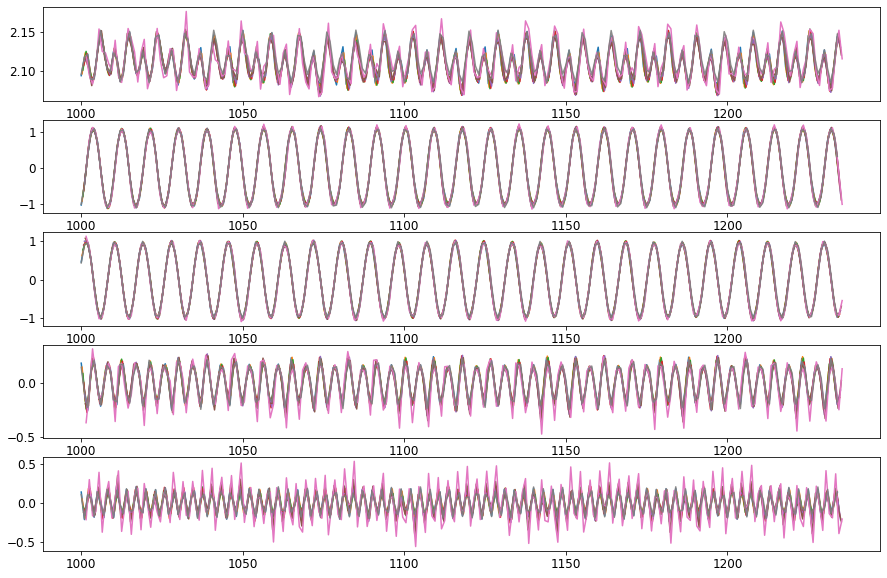

In [67]:
fig, ax = plt.subplots(5,1, figsize=[15,10])
for i in range(5):
    ax.flatten()[i].plot(np.arange(1000,1235,step*4), X_0[:,i])
    ax.flatten()[i].plot(np.arange(1000+step,1235+step,step*4), X_1[:,i])
    ax.flatten()[i].plot(np.arange(1000+step*2,1235+step*2,step*4), X_2[:,i])
    ax.flatten()[i].plot(np.arange(1000+step*3,1235+step*3,step*4), X_3[:,i])
    ax.flatten()[i].plot(np.arange(1000+step*4,1235+step*4,step*4), X_4[:,i])
    ax.flatten()[i].plot(np.arange(1000+step*5,1235+step*5,step*4), X_5[:,i])
    ax.flatten()[i].plot(np.arange(1000+step*6,1235+step*6,step*4), X_6[:,i])
    ax.flatten()[i].plot(np.arange(1000,1235,step*4),X_pod[1000:1940:4,i], alpha=0.9)

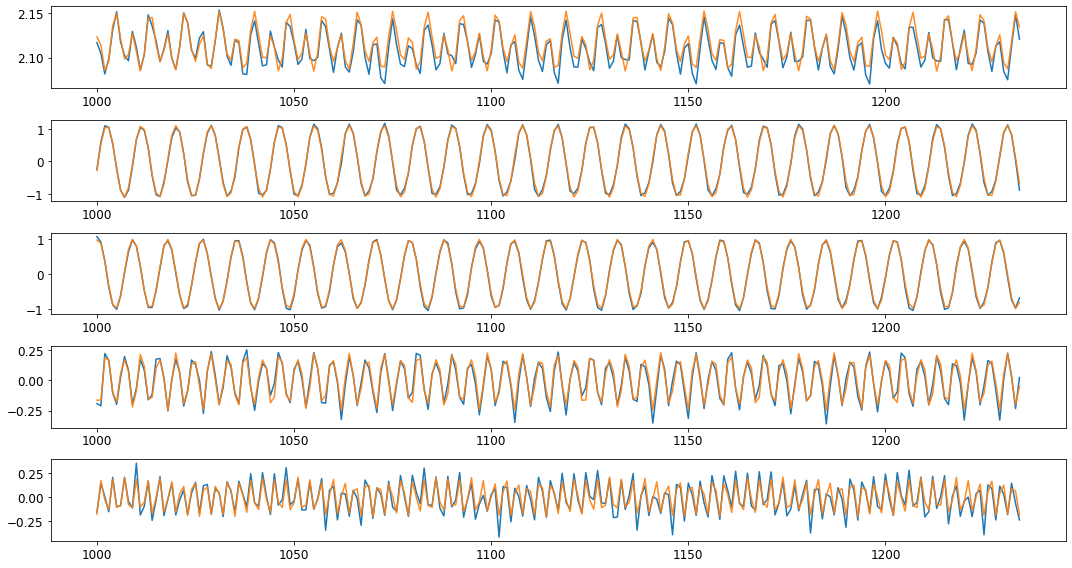

In [88]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):
    #ax.flatten()[i].plot(np.arange(1000,1235,step*4), X_2[:,i])
    #ax.flatten()[i].plot(np.arange(1000,1235,step*4),X_pod[1002:1942:4,i], alpha=0.9)
    
    #ax.flatten()[i].plot(np.arange(1000,1235,step*4), X_4[:,i])
    #ax.flatten()[i].plot(np.arange(1000,1235,step*4),X_pod[1004:1944:4,i], alpha=0.9)
    
    ax.flatten()[i].plot(np.arange(1000,1235,step*4), X_5[:,i])
    ax.flatten()[i].plot(np.arange(1000,1235,step*4),X_pod[1005:1945:4,i], alpha=0.9)
    
plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

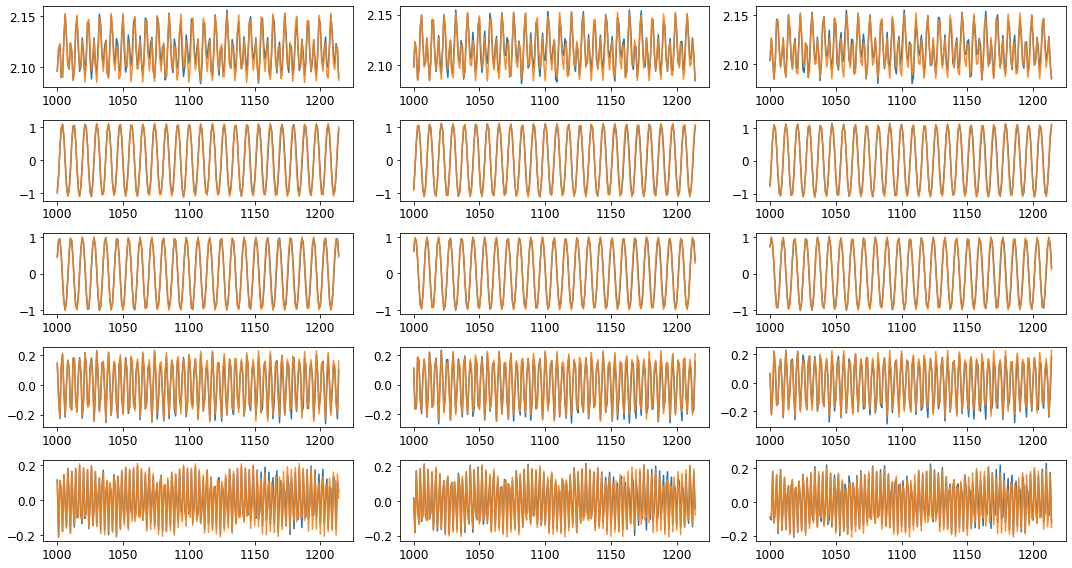

In [64]:
fig, ax = plt.subplots(5,3, figsize=[15,8])
for i in range(5):
    ax.flatten()[i*3].plot(np.arange(1000,1215,step*4), X_generated[:,i])
    ax.flatten()[i*3].plot(np.arange(1000,1215,step*4),X_pod[1000:1860:4,i], alpha=0.9)
    
    ax.flatten()[i*3+1].plot(np.arange(1000,1215,step*4), X_pred_1[:,i])
    ax.flatten()[i*3+1].plot(np.arange(1000,1215,step*4),X_pod[1001:1861:4,i], alpha=0.9)
    
    ax.flatten()[i*3+2].plot(np.arange(1000,1215,step*4), X_pred_2[:,i])
    ax.flatten()[i*3+2].plot(np.arange(1000,1215,step*4),X_pod[1002:1862:4,i], alpha=0.9)
    
plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

In [97]:
X_pred = []
for i in range(ntimes+200):
    X_pred.append(X_0[i,:])
    X_pred.append(X_1[i,:])
    X_pred.append(X_2[i,:])
    X_pred.append(X_3[i,:])
X_pred = np.array(X_pred)

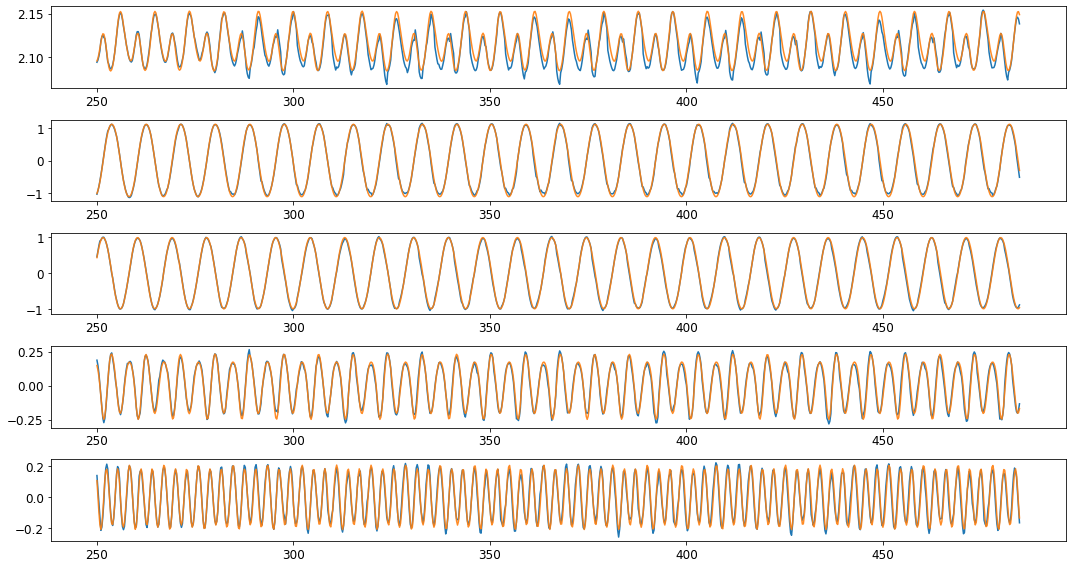

In [99]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):  
    ax.flatten()[i].plot(times[1000:1940], X_pred[:,i])
    ax.flatten()[i].plot(times[1000:1940],X_pod[1000:1940,i], alpha=0.9)
    
plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

Output as `csv`

In [100]:
pod_coeffs_gen = np.transpose(X_pred)
np.savetxt('POD_coeffs_new_gan_deriv_6.csv', pod_coeffs_gen , delimiter=',')

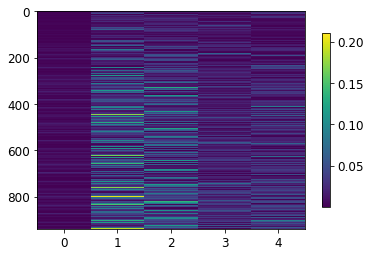

In [101]:
error = X_pred-X_pod[1000:1940,:]
pod_coeffs_error = np.transpose(error)
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)